## Homework part B: implementing a sample size estimator for interleaving experiments

#### by Kim de Bie, Bram van den Heuvel and Kiki van Rongen

In [2]:
import pandas as pd
import csv
import random
from collections import defaultdict, Counter
import copy
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import texttable as tt

### Step 1: Simulate Rankings of Relevance for E and P

In the first step we generate pairs of rankings, for the production P and experimental E, respectively. We assume a binary relevance. Documents can be distinct but they may also overlap. Further, we assume that the algorithms are used on mobiles, so we are interested only in rankings of length 3. 

In [3]:
class Ranking:

    def __init__(self, id, ranker):
        self.id = id
        self.ERR = 0
        self.ranker = ranker
        self.ranking = [{'id': 1, 'relevance': 0}, {'id': 2, 'relevance': 0}, {'id': 3, 'relevance': 0}]

    def set_ERR(self):
        self.ERR = self.calculate_ERR()
        
    def calculate_ERR(self):

        max_rl = 1

        thetas = []
        for idx, docu in enumerate(self.ranking):
            rl = docu['relevance']
            thetas.append((2**rl - 1) / (2**max_rl))
            

        # calculate ERR as sum of products
        ERR = 0
        for rank, doc in enumerate(self.ranking):
            prod = 1
            for i in range(rank):
                prod *= (1-thetas[i])
            ERR+= (prod * thetas[rank])/ (rank+1)
            
        return ERR
    

class Pair:
    
    def __init__(self, ranking_E, ranking_P):
        self.rankings = [ranking_E, ranking_P]
        self.delta_ERR = ranking_E.ERR - ranking_P.ERR


def create_pairs():

    """
    This function creates two ranked lists of documents for algorithm P and E.
    Subsequently, it forms E-P pairs of possible rankings.
    """

    ############### CREATE RANKED LIST FOR E ###############

    rankings_E = []
    rankings_P = []

    # define all possible combinations of relevance labels
    rl_permutations = [[0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]]

    # assign id to the rankings
    id = 0

    # iterate over permutations of relevance labels
    for rl_perm in rl_permutations:

        # create ranking object and adjust its relevance labels
        rank_E = Ranking(id, 'E')
        for i, document_E in enumerate(rank_E.ranking):
             document_E['relevance'] = rl_perm[i]

        # calculate ERR
        rank_E.set_ERR()

        # store ranking list for E
        rankings_E.append(rank_E)
        id += 1

    ############### CREATE RANKED LIST FOR P ###############

    # define all possible id's for P
    id_permutations = [[1, 5, 6], [2, 5, 6], [3, 5, 6], [4, 5, 6], \
                       [4, 1, 6], [4, 2, 6], [4, 3, 6], \
                       [4, 5, 1], [4, 5, 2], [4, 5, 3], \
                       [1, 2, 6], [1, 5, 2], [4, 1, 2], \
                       [1, 3, 6], [1, 5, 3], [4, 1, 3], \
                       [2, 3, 6], [2, 5, 3], [4, 2, 3], \
                       [2, 1, 6], [2, 5, 1], [4, 2, 1], \
                       [3, 1, 6], [3, 5, 1], [4, 3, 1], \
                       [3, 2, 6], [3, 5, 2], [4, 3, 2], \
                       [1, 2, 3], [1, 3, 2], [3, 1, 2], [3, 2, 1], [2, 1, 3], [2, 3, 1]]

    # iterate over possible id's for P
    for id_perm in id_permutations:

        # iterate over permutations of relevance labels
        for rl_perm in rl_permutations:

            # create ranking object for P
            rank_P = Ranking(id, 'P')

            # adjust relevance labels & id numbers
            for j, document_P in enumerate(rank_P.ranking):
                document_P['relevance'] = rl_perm[j]
                document_P['id'] = id_perm[j]

            # calculate ERR
            rank_P.set_ERR()

            # store ranking list for P
            rankings_P.append(rank_P)
            id += 1

    ############### FORM E-P PAIRS ###############

    pairs = []

    for rank_E in rankings_E:

        # store ids and relevance labels of E
        ids_E = [1, 2, 3]
        rl_E = [d.get('relevance') for d in rank_E.ranking]

        for rank_P in rankings_P:

            # keep track of errors (duplicates with non-matching rl's)
            error = False

            # store ids and relevance labels of P
            ids_P = [d.get('id') for d in rank_P.ranking]
            rl_P = [d.get('relevance') for d in rank_P.ranking]

            # iterate over ids of P
            for idx, id in enumerate(ids_P):

                # check for duplicates with non-matching relevance labels
                if (id in ids_E) & (rl_P[idx] != rl_E[idx]):
                    error = True
                    break

            # create pair and add to list, if no error occurs
            if not error:
                pair = Pair(rank_E, rank_P)
                if 0.05 < pair.delta_ERR < 0.95:
                    pairs.append(pair)

    return pairs

pairs = create_pairs()
counter = Counter()
for i, p in enumerate(pairs):
    counter[p.delta_ERR] += 1
        
print(counter)

Counter({0.16666666666666666: 26, 0.5: 17, 0.25: 17, 0.3333333333333333: 17, 0.125: 13, 0.375: 13, 0.08333333333333337: 13, 0.41666666666666674: 13, 0.08333333333333331: 13, 0.08333333333333326: 13, 0.33333333333333337: 5, 0.08333333333333334: 4, 0.625: 4, 0.2916666666666667: 4, 0.5833333333333334: 4, 0.25000000000000006: 4, 0.16666666666666663: 4, 0.41666666666666663: 4, 0.16666666666666669: 1, 0.45833333333333337: 1, 0.6666666666666666: 1})


### Step 2: Calculate the 𝛥ERR
Implement the aforementioned measure, ERR.

For all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P and group them such that group 1 contains all pairs for which 0.05 < 𝛥measure ≤ 0.1, group 2 all pairs for which 0.1 < 𝛥measure ≤ 0.2, etc.

In [4]:
# See previous step for loading pairs and calculation of (delta-)ERR.

def create_groups(pairs):
    """
    This function separates pairs into groups based on delta_ERR intervals.
    It returns a list of sublists; each sublists contains an object of class Pair
    """

    group1 = [p for p in pairs if (p.delta_ERR>=0.05 and p.delta_ERR<0.1)]
    group2 = [p for p in pairs if (p.delta_ERR>=0.1 and p.delta_ERR<0.2)]
    group3 = [p for p in pairs if (p.delta_ERR>=0.2 and p.delta_ERR<0.3)]
    group4 = [p for p in pairs if (p.delta_ERR>=0.3 and p.delta_ERR<0.4)]
    group5 = [p for p in pairs if (p.delta_ERR>=0.4 and p.delta_ERR<0.5)]
    group6 = [p for p in pairs if (p.delta_ERR>=0.5 and p.delta_ERR<0.6)]
    group7 = [p for p in pairs if (p.delta_ERR>=0.6 and p.delta_ERR<0.7)]
    group8 = [p for p in pairs if (p.delta_ERR>=0.7 and p.delta_ERR<0.8)]
    group9 = [p for p in pairs if (p.delta_ERR>=0.8 and p.delta_ERR<0.9)]
    group10 = [p for p in pairs if (p.delta_ERR>=0.9 and p.delta_ERR<=0.95)]

    data = [group1, group2, group3, group4, group5, group6, group7, \
            group8, group9, group10]
    
    return data

### Step 3: Implement Team-Draft Interleaving and Probabilistic Interleaving

Implement Team-Draft and Probabilistic Interleaving, with methods that interleave two rankings, and given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.


In [5]:
class Interleaved:
    def __init__(self, pair):
        """
        A class containing a pair of rankings, has methods to interleave
        these rankings into a list as well as counters to keep track of how
        often pair.rankings[0] (or E) wins.
        input:
            pair: A Pair object as defined earlier in the notebook
        """
        self.pair = pair
        self.list = None
        self.wins_team_draft = 0
        self.wins_probabilistic = 0

    def team_draft(self):
        """
        Modifies self.list in place.
        Takes the rankings in self.pair and merges them using team draft
        interleaving. The interleaved list contains tuples of form
        (relevance, ranker).
        """
        interleaved_list = []
        available_E = set([i["id"] for i in self.pair.rankings[0].ranking])
        available_P = set([i["id"] for i in self.pair.rankings[1].ranking])
        available = available_E.union(available_P)
        team = [0,0]

        while len(available_E.intersection(available)) > 0 \
                and len(available_P.intersection(available)) > 0:

            # Flip a coin to determine which ranker is first
            ranker = int(team[0] > team[1] or (team[0] == team[1]
                         and random.choice([0,1]) == 1))

            for document in self.pair.rankings[ranker].ranking:
                if document["id"] in available:
                    interleaved_list.append((document["relevance"], ranker))
                    available.remove(document["id"])
                    team[ranker] += 1
                    break


        self.list = interleaved_list[:3]

    def probabilistic(self):
        """
        Modifies self.list in place.
        Takes the rankings in self.pair and merges them using probabilistic
        interleaving. The interleaved list contains tuples of form
        (relevance, ranker).
        """
        l1 = copy.copy(self.pair.rankings[0].ranking)
        l2 = copy.copy(self.pair.rankings[1].ranking)
        lists = [l1, l2]
        interleaved_list = []

        # As long as some thing is still true:
        while len(l1) > 0 and len(l2) > 0:

            # Randomly select one of the lists
            ranker = random.choice([0,1])
            random_l = lists[ranker]

            # Sample d from lx using a softmax
            document_rank = self.sample_softmax(len(random_l))
            document = random_l[document_rank]

            # Put d in l and remove from l1 and l2
            interleaved_list.append((document["relevance"], ranker))
            for l in lists:
                try:
                    l.remove(document)
                except ValueError:
                    pass

        self.list = interleaved_list[:3]

    def sample_softmax(self, length):
        """
        Returns an integer from 0 to length according to a softmax
        function.
        """
        normalization = sum([1/i**3 for i in range(1, length + 1)])

        sample = random.random()
        total = 0

        for i in range(1, length + 1):
            total += (1/i**3)/normalization
            if sample < total:
                return i - 1

        # You should never get here error
        raise notImplementedError()

### Step 4:  Simulate user clicks
Having interleaved all the ranking pairs in each group (for each measure) an online experiment could be ran. However, given that we do not have any real users (and the entire homework is a big simulation) we will simulate user clicks.

We consider the Position Based Model (PBM) for clicks. The parameters of PBM are estimated based on the Expectation-Maximization (EM) method. We first learn the parameters of the model given the Yandex Click Log. We predict the click probability given a ranked list of relevance labels. Then, we decide - stochastically - whether a document is clicked based on these probabilities.

After training PBM, we use the learnt parameters γr , while instead of the 𝑎uq learnt we use epsilon for the non-relevant documents (for a small value of ) and 1-epsilon for the relevant documents.

We further consider and implement a Random Click Model, which will be used for sanity check.


In [6]:
import pandas as pd
import csv
import random
from collections import defaultdict

filename = "../data/YandexRelPredChallenge.txt"

def load_data(data):
    '''This function loads data into an appropriate form for further analysis.
    Input: Yandex Click Log file
    Output: a pandas dataframe with rows of format [QueryID, [ResultIDs], [Clicked]]'''

    completed_queries = []
    rank = 3

    with open(data) as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:

            if row[2] == 'Q':
                try:
                    completed_queries.append(query)
                except:
                    pass
                query = row
                query.append([])
                query.append([])

                for i in range(5, rank+5):
                    query[15].append(query[i])
                    query[16].append(False)

            else:
                for i in range(0, rank):
                    if row[3] == query[15][i]:
                        query[16][i] = True

    headers = ['SessionID', 'TimePassed', 'TypeOfAction', 'QueryID', 'RegionID', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'ResultIDs', 'Clicked']
    qd_pairs = pd.DataFrame(completed_queries, columns=headers)
    qd_pairs = qd_pairs[['QueryID', 'ResultIDs', 'Clicked']]

    return qd_pairs

def learn_model_parameters(qd_pairs):

    '''This method takes as input the Yandex click log. It trains the alpha and
     gamma parameters for the PBM model on the basis of this file. It saves the
    alphas and gammas (so they only have to be trained once) to a csv and
    returns them.'''

    iterations = 50

    ## EM algorithm for finding optimal alpha and gamma ##

    # Set parameters to initial values
    max_rank = 3
    alphas = defaultdict(lambda: 0.5)
    gammas = [0.5] * max_rank

    for ctr in range(0, iterations):
        print("Round " + str(ctr))

        print("Update alphas")

        # update one alpha for each QD pair
        new_alphas = defaultdict(lambda:1)
        qd_count = defaultdict(lambda:2)

        for i, session in qd_pairs.iterrows():

            if i%10000 == 0:
                print(str(i) + " sessions visited")

            for rank in range(max_rank):
                query = session["QueryID"]
                result = session["ResultIDs"][rank]
                click_u = float(session["Clicked"][rank])

                old_alpha = max(alphas[(query, result)], 0.000001)
                old_gamma = max(gammas[rank], 0.000001)

                qd_count[(query, result)] += 1

                # add new weights to dictionary
                new_alphas[(query, result)] += click_u + (1-click_u) * \
                ((1-old_gamma)*old_alpha / (1-old_gamma*old_alpha))

        for key, value in qd_count.items():
            new_alphas[key] /= value

        alphas = new_alphas


        print("Update gammas")

        new_gammas = [0] * max_rank

        # update one gamma per rank
        for i, session in qd_pairs.iterrows():

            if i%10000 == 0:
                print(str(i) + " sessions visited")

            for rank in range(max_rank):
                query = session["QueryID"]
                result = session["ResultIDs"][rank]
                click_u = float(session["Clicked"][rank])
                old_gamma = gammas[rank]
                old_alpha = alphas[(query, result)]

                new_gammas[rank] += click_u + (1-click_u) * \
                    (old_gamma*(1-old_alpha)) / (1-old_gamma*old_alpha)

        for rank, value in enumerate(gammas):
            gammas[rank] = new_gammas[rank] / qd_pairs.shape[0]

        print(gammas)

    alphas_df = pd.DataFrame.from_dict(alphas, orient='index')
    alphas_df.to_csv('trained_alphas.csv')

    gammas_df = pd.DataFrame({'gammas': gammas})
    gammas_df.to_csv('trained_gammas.csv')

    return alphas, gammas

def get_gammas_from_file():
    '''Use this method to load gammas when parameters are already trained.'''

    try:
        gammas = pd.read_csv('trained_gammas.csv')
        gammas = gammas['gammas'].tolist()

        return gammas

    except:
        print("File not found!")

def predict_click_probability(interleaving, gammas):

    '''This method takes as input an Interleaving object and a list
    of gamma parameters that determine the examination probability per rank.
    The method calculates its own alpha parameters. It returns the click
    probabilities of the ranked list (also as a list).'''

    # set epsilon to small value (prob that a not-relevant document is clicked)
    epsilon = 1e-6

    click_probabilities = []

    for rank, item in enumerate(interleaving.list):

        relevance = item[0]

        # check relevance label to determine alphas
        if relevance == 1:
            alpha = 1-epsilon
        else:
            alpha = epsilon

        # determine gamma
        gamma = gammas[rank]

        click_prob = alpha * gamma
        click_probabilities.append(click_prob)

    return click_probabilities



def click_documents(interleaved, click_probabilities):
    '''This method takes as input a ranked list of documents (Interleaved.list)
    and the click probabilities for each rank. It returns an integer representing
    whether Interleaved.pair[0] (E) won or not.'''

    clicked = Counter()

    for rank, item in enumerate(interleaved.list):

        rand = random.uniform(0, 1)

        if rand < click_probabilities[rank]:
            clicked[item[1]] += 1

    # If it's a tie return 0.5, else return 1 if E wins and 0 if P wins.
    if clicked[0] == clicked[1]:
        return 0.5
    else:
        return int(clicked[0] > clicked[1])

def random_click_model(qd_pairs):

    '''This method takes the dataset with all sessions and returns the click
    probabilities trained using the random click model. Probabilities are returned
    in a length of maximum rank for convenience.'''
    max_rank = 3
    clicks = 0
    docs = 0

    for i, session in qd_pairs.iterrows():
        for rank in range(max_rank):
            docs += 1
            if session["Clicked"][rank]:
                clicks += 1

    click_prob = clicks / docs

    click_probs = [click_prob] * max_rank

    return click_probs

def get_model_parameters():
    """
    Tries to take gammas from a file, if the file doesn't exist train
    parameters to get the gammas.
    """
    gammas = get_gammas_from_file()
    if not gammas == None:
        return gammas
    else:
        qd_pairs = load_data(data)
        _, gammas = learn_model_parameters(qd_pairs)
        return gammas


In [7]:
data = "data/YandexRelPredChallenge.txt"

gammas = get_model_parameters()
print(gammas)

[0.9956892329152498, 0.4826360728234162, 0.3336191638862573]


### Step 5: Simulate interleaving experiment
Having implemented the click model, it is time to run the simulated experiment.

For each of interleaving experiment run k simulations for each one of the two click models implemented and measure the proportion p of wins for E. Group these proportions in the respective group the interleaved ranking came from. The larger the k the better, but also the larger the k the longer it takes to run the experiment; so make a reasonable choice.


In [8]:
def online_experiment(interleaving, gammas, k):
    """
    Modifies an Interleaved object in place to contain the number of wins 
    for both interleaving methods.
    """
    cntr = Counter()
    for i in range(k):
        # Run the experiment for team draft interleaving
        interleaving.team_draft()
        win = click_documents(interleaving, predict_click_probability(interleaving, gammas))
        interleaving.wins_team_draft += win/k
        cntr[win] += 1

        # Run the experiment for probabilistic interleaving
        interleaving.probabilistic()
        win = click_documents(interleaving, predict_click_probability(interleaving, gammas))
        interleaving.wins_probabilistic += win/k
        cntr[win] += 1

def simulate_experiment(pairs, gammas, k):
    """
    Creates a list of Interleaved objects that contain both ERR and number
    of wins for the team draft and probabilistic methods of interleaving.
    """
    interleavings = []
    for i, pair in enumerate(pairs):
        interleaving = Interleaved(pair)

        # Modify the interleaving object in place
        online_experiment(interleaving, gammas, k)

        interleavings.append(interleaving)

    return interleavings


In [9]:
# Get all the experiment results (only takes ~30 sec)
interleavings = simulate_experiment(pairs, gammas, 1000)

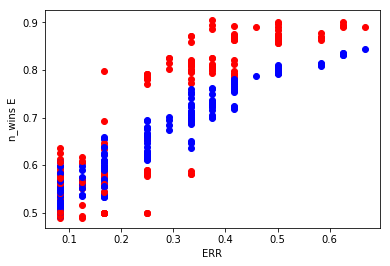

In [10]:
for i, interleaving in enumerate(interleavings):
    plt.plot(interleaving.pair.delta_ERR, interleaving.wins_team_draft, 'ro')
    plt.plot(interleaving.pair.delta_ERR, interleaving.wins_probabilistic, 'bo')
    
plt.xlabel("ERR")
plt.ylabel("n_wins E")
plt.show()

### Step 6: Compute sample size
Use each one of the afore-computed proportions to compute the sample size needed to detect such a proportion in a statistically significant manner. Allow a chance of falsely rejecting the null hypothesis (i.e. concluding that E is better than P, when it is not) of 5% and a chance of falsely not rejecting the null hypothesis (i.e. not concluding that E is better than P, when it is) of 10%. Use the values above for a power analysis of the proportion test, for the 1-sided case.


In [17]:
def determine_sample_size(alpha, beta, p1):
    
    p0 = 0.5
    z_alpha = st.norm.ppf(1-alpha) 
    z_beta = st.norm.ppf(1-beta)
    min_N = ((z_alpha * (p0*(1-p0))**.5 + z_beta * (p1*(1-p1))) / (np.abs(p1-p0)))**2
    
    # continutity correction 
    N = min_N + 1 / (np.abs(p1-p0))
    
    return N

def sample_size_interval(all_sample_sizes):
    if not all_sample_sizes:
        minimum, median, maximum = 0, 0, 0
        
    else: 
        np.array(all_sample_sizes)
        median = np.median(all_sample_sizes)
        maximum = np.max(all_sample_sizes)
        minimum = np.min(all_sample_sizes)
    
    return minimum, median, maximum

alpha = 0.05
beta = 0.1
all_n_team_draft = []
all_n_probabilistic = []

for interleaving in interleavings:
    p1_t = interleaving.wins_team_draft
    p1_p = interleaving.wins_probabilistic
    
    delta_ERR_t = interleaving.pair.delta_ERR
    delta_ERR_p = interleaving.pair.delta_ERR
    
    N_t = determine_sample_size(alpha, beta, p1_t)
    N_p = determine_sample_size(alpha, beta, p1_p)
    all_n_team_draft.append((delta_ERR_t, N_t))
    all_n_probabilistic.append((delta_ERR_p, N_p))
    
# seperate results based on delta_ERR
group1 = [result[1] for result in all_n_team_draft if (result[0]>=0.05 and result[0]<0.1)]
group2 = [result[1] for result in all_n_team_draft if (result[0]>=0.1 and result[0]<0.2)]
group3 = [result[1] for result in all_n_team_draft if (result[0]>=0.2 and result[0]<0.3)]
group4 = [result[1] for result in all_n_team_draft if (result[0]>=0.3 and result[0]<0.4)]
group5 = [result[1] for result in all_n_team_draft if (result[0]>=0.4 and result[0]<0.5)]
group6 = [result[1] for result in all_n_team_draft if (result[0]>=0.5 and result[0]<0.6)]
group7 = [result[1] for result in all_n_team_draft if (result[0]>=0.6 and result[0]<0.7)]
group8 = [result[1] for result in all_n_team_draft if (result[0]>=0.7 and result[0]<0.8)]
group9 = [result[1] for result in all_n_team_draft if (result[0]>=0.8 and result[0]<0.9)]
group10 = [result[1] for result in all_n_team_draft if (result[0]>=0.9 and result[0]<=0.95)]

results_team_draft = {'[0.05-0.1)': group1, '[0.1-0.2)': group2, '[0.2-0.3)': group3, '[0.3-0.4)': group4, \
                      '[0.4-0.5)': group5, '[0.5-0.6)': group6, '[0.6-0.7)': group7, '[0.7-0.8)': group8, \
                      '[0.8-0.9)': group9, '[0.9-0.95]': group10}

group1_p = [result[1] for result in all_n_probabilistic if (result[0]>=0.05 and result[0]<0.1)]
group2_p = [result[1] for result in all_n_probabilistic if (result[0]>=0.1 and result[0]<0.2)]
group3_p = [result[1] for result in all_n_probabilistic if (result[0]>=0.2 and result[0]<0.3)]
group4_p = [result[1] for result in all_n_probabilistic if (result[0]>=0.3 and result[0]<0.4)]
group5_p = [result[1] for result in all_n_probabilistic if (result[0]>=0.4 and result[0]<0.5)]
group6_p = [result[1] for result in all_n_probabilistic if (result[0]>=0.5 and result[0]<0.6)]
group7_p = [result[1] for result in all_n_probabilistic if (result[0]>=0.6 and result[0]<0.7)]
group8_p = [result[1] for result in all_n_probabilistic if (result[0]>=0.7 and result[0]<0.8)]
group9_p = [result[1] for result in all_n_probabilistic if (result[0]>=0.8 and result[0]<0.9)]
group10_p = [result[1] for result in all_n_probabilistic if (result[0]>=0.9 and result[0]<=0.95)]

results_probabilistic = {'[0.05-0.1)': group1_p, '[0.1-0.2)': group2_p, '[0.2-0.3)': group3_p, '[0.3-0.4)': group4_p, \
                         '[0.4-0.5)': group5_p, '[0.5-0.6)': group6_p, '[0.6-0.7)': group7_p, '[0.7-0.8)': group8_p, \
                         '[0.8-0.9)': group9_p, '[0.9-0.95]': group10_p}

minimums_t, minimums_p, medians_t, medians_p, maximums_t, maximums_p = [], [], [], [], [], []

for group in results_team_draft.values():
    minimum_t, median_t, maximum_t = sample_size_interval(group)
    minimums_t.append(minimum_t)
    medians_t.append(median_t)
    maximums_t.append(maximum_t)
    
for group in results_probabilistic.values():
    minimum_p, median_p, maximum_p = sample_size_interval(group)
    minimums_p.append(minimum_p)
    medians_p.append(median_p)
    maximums_p.append(maximum_p)
    
  
print("Results team-draft interleaving:")    
table_t = tt.Texttable()
headers = ['Delta_ERR', 'Minimum', 'Median', 'Maximum']
table_t.header(headers)
deltaERR = ['[0.05-0.1)', '[0.1-0.2)', '[0.2-0.3)', '[0.3-0.4)', '[0.4-0.5)', '[0.5-0.6)', '[0.6-0.7)', \
            '[0.7-0.8)', '[0.8-0.9)', '[0.9-0.95]']

for row in zip(deltaERR, minimums_t, medians_t, maximums_t):
    table_t.add_row(row)
tab_t = table_t.draw()
print(tab_t)
print('\n')
print("Results probabilistic interleaving:")    
table_p = tt.Texttable()
headers = ['Delta_ERR', 'Minimum', 'Median', 'Maximum']
table_p.header(headers)
deltaERR = ['[0.05-0.1)', '[0.1-0.2)', '[0.2-0.3)', '[0.3-0.4)', '[0.4-0.5)', '[0.5-0.6)', '[0.6-0.7)', \
            '[0.7-0.8)', '[0.8-0.9)', '[0.9-0.95]']

for row in zip(deltaERR, minimums_p, medians_p, maximums_p):
    table_p.add_row(row)
tab_p = table_p.draw()
print(tab_p)

Results team-draft interleaving:
+------------+---------+---------+-----------+
| Delta_ERR  | Minimum | Median  |  Maximum  |
+============+=========+=========+===========+
| [0.05-0.1) | 76.169  | 472.060 | 1.177e+31 |
+------------+---------+---------+-----------+
| [0.1-0.2)  | 15.279  | 252.749 | 1.177e+31 |
+------------+---------+---------+-----------+
| [0.2-0.3)  | 12.602  | 51.771  | 1.177e+31 |
+------------+---------+---------+-----------+
| [0.3-0.4)  | 7.794   | 14.142  | 211.043   |
+------------+---------+---------+-----------+
| [0.4-0.5)  | 8.398   | 9.818   | 16.730    |
+------------+---------+---------+-----------+
| [0.5-0.6)  | 7.951   | 9.596   | 10.361    |
+------------+---------+---------+-----------+
| [0.6-0.7)  | 7.973   | 8.349   | 8.496     |
+------------+---------+---------+-----------+
| [0.7-0.8)  | 0       | 0       | 0         |
+------------+---------+---------+-----------+
| [0.8-0.9)  | 0       | 0       | 0         |
+------------+---------+---

### Step 7: Analysis

* Report the aforementioned tables for the Random Click Model and PBM and for the two interleaving methods [5pts];
* Analyze the results and report your conclusions by observing the results of the experiment [10pts];
* Based on the literature, suggest possible improvements to the experimental design and how would you implement them [5pts].
